# Picking strategies

Different strategies for picking test and training sets.

http://rdkit.blogspot.co.uk/2014/08/picking-diverse-compounds-from-large.html

In [34]:
from itertools import chain, combinations

from math import ceil

from rdkit import SimDivFilters,DataStructs

from local_utils.rdkit_utils import FP

In [35]:
def get_cluster_partition(mols, method, max_tries=10):
    
    from itertools import takewhile
    
    n_mols = mols.shape[0]

    target_n = int(ceil(n_mols / 4))
    
    threshold = 2 # int(ceil(target_n/20))
    
    clusters = mols[[method + '_cluster', method + '_count']].drop_duplicates().reset_index(drop=True)
    
    n_clusters = clusters.shape[0]
    
    logging.info("No. mols = {}; target no. = {}; delta threshold = {}; no. clusters = {}".format(n_mols, target_n, threshold, n_clusters))

    def f(x):
        
        delta = target_n - clusters.iloc[:x][method + '_count'].sum()
        
        return delta < 0 or delta > threshold
    
    for try_n in range(max_tries):
        
        indices = list(takewhile(f, clusters.index))
        
        test_clusters = clusters.iloc[indices][method + '_cluster']
                
        test_mol_idx = mols.query("{}_cluster in @test_clusters".format(method)).index
        
        # logging.info("{:2d}) test clusters: [{}]".format(try_n, ', '.join("{}".format(x) for x in test_clusters)))
            
        logging.info("{:2d}) candidate total: {}".format(try_n, len(test_mol_idx)))
                        
        if len(test_clusters) < n_clusters:
                        
            logging.info("Generated a partition: test size = {} (target = {}).".format(len(test_mol_idx), target_n))

            return mols.index.get_indexer(test_mol_idx)
                
        clusters = clusters.loc[np.random.permutation(clusters.index)].reset_index(drop=True)
        
    logging.warn("Failed to generate a partition.")
        
    return None

In [60]:
def check_split(df, test_indices):
    
    test, train  = df.iloc[test_indices], df.loc[~df.reset_index().index.isin(test_indices)] # Partition

    assert all((pd.concat([test, train], axis=0).sort_index() == df).unstack()) # Sanity check: check partition concatenated and resorted is same as original

    return test.shape, train.shape

In [110]:
def plot_sim_histograms(sims, test_indices, vertical=False, width=0.05, title=None):
    
    """Plot histograms of similarities"""
    
    if vertical:

        fig, axes = plt.subplots(3, 1)

        fig.set_size_inches(10, 15)

    else:
        
        fig, axes = plt.subplots(1, 3)

        fig.set_size_inches(33, 4)
        
    if title: fig.suptitle(title, y=1.1, fontsize=20)
        
    for ax in axes: ax.set_xlim(0.0, 1.0)
        
    # Full set...

    sims0 = sims['sim'].tolist()                                                            

    axes[0].hist(sims0, bins=np.arange(0.0 + width, 1.0 + width, width))
    
    axes[0].set_title("{} ({:d}, {:.3f}, {:.3f})".format('Full',      n_mols, np.mean(sims0), np.median(sims0)))
    
    # Test set...
    
    sims1 = sims.query("i     in @test_indices and j     in @test_indices")['sim'].tolist() 
    
    axes[1].hist(sims1, bins=np.arange(0.0 + width, 1.0 + width, width))
    
    axes[1].set_title("{} ({:d}, {:.3f}, {:.3f})".format('Test',     len(test_indices), np.mean(sims1), np.median(sims1)))
    
    # Training set...
    
    sims2 = sims.query("i not in @test_indices and j not in @test_indices")['sim'].tolist()
    
    axes[2].hist(sims2, bins=np.arange(0.0 + width, 1.0 + width, width))
    
    axes[2].set_title("{} ({:d}, {:.3f}, {:.3f})".format('Training', n_mols - len(test_indices), np.mean(sims2), np.median(sims2)))
        
    plt.subplots_adjust(top=0.90)
    
    return None # np.around([np.mean(sims0), np.median(sims0), np.mean(sims1), np.median(sims1), np.mean(sims2), np.median(sims2)], 3)

## Reload cluster data

In [37]:
# Cluster data...

clusterings = pickle.load(open('clusterings.pkl', 'r'))

len(clusterings)

138

,mol,FP,core_smiles,core_cluster,core_count,affinity_cluster,affinity_count
usmiles,,,,,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12,258,43,0,6

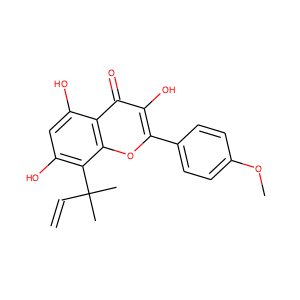

In [38]:
clusterings['ABCB1'].head(1)

## Partitioning

In [39]:
# Target...

symbol = 'ABCB1'

# symbol = 'KCNQ1'

In [40]:
df = clusterings[symbol]

n_mols = df.shape[0]

n_mols

652

In [41]:
# Precompute all similarities for target and store in DataFrame...

sims = [(i, j, DataStructs.TanimotoSimilarity(df.iloc[i]['FP'].bv, df.iloc[j]['FP'].bv)) for i, j in combinations(range(df.shape[0]), 2)]

sims = pd.DataFrame(sims, columns=['i', 'j', 'sim'])

sims.shape

(212226, 3)

In [42]:
# Aim is to partition set into 75% training and 25% test sets...

target_n = int(ceil(n_mols / 4)) # NB Target number for test set

n_mols,  n_mols - target_n, target_n

(652, 489, 163)

### Random Picking

In [62]:
test_indices1 = np.random.choice(range(df.shape[0]), size=target_n, replace=False)

check_split(df, test_indices1)

((163, 7), (489, 7))

In [64]:
# _ = plot_sim_histograms(sims, test_indices1, vertical=True)

### Diversity Picking

In [65]:
picker = SimDivFilters.MaxMinPicker()

test_indices2 = list(picker.LazyBitVectorPick([x.bv for x in df['FP']], n_mols, target_n))

check_split(df, test_indices2)

((163, 7), (489, 7))

In [66]:
# _ = plot_sim_histograms(sims, test_indices2, vertical=True)

### Core clusters

In [49]:
test_indices3 = get_cluster_partition(df, 'core')

check_split(df, test_indices3)

[2015/Aug/14 11:11:05 INFO    ] No. mols = 652; target no. = 163; delta threshold = 2; no. clusters = 345
[2015/Aug/14 11:11:05 INFO    ]  0) candidate total: 163
[2015/Aug/14 11:11:05 INFO    ] Generated a partition: test size = 163 (target = 163).


In [68]:
# _ = plot_sim_histograms(sims, test_indices3, vertical=True)

### Affinity clusters

In [67]:
test_indices4 = get_cluster_partition(df, 'affinity')

check_split(df, test_indices4)

[2015/Aug/14 11:18:36 INFO    ] No. mols = 652; target no. = 163; delta threshold = 2; no. clusters = 76
[2015/Aug/14 11:18:36 INFO    ]  0) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  1) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  2) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  3) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  4) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  5) candidate total: 652
[2015/Aug/14 11:18:36 INFO    ]  6) candidate total: 161
[2015/Aug/14 11:18:36 INFO    ] Generated a partition: test size = 161 (target = 163).


((161, 7), (491, 7))

In [69]:
# _ = plot_sim_histograms(sims, test_indices4, vertical=True)

### Comparison

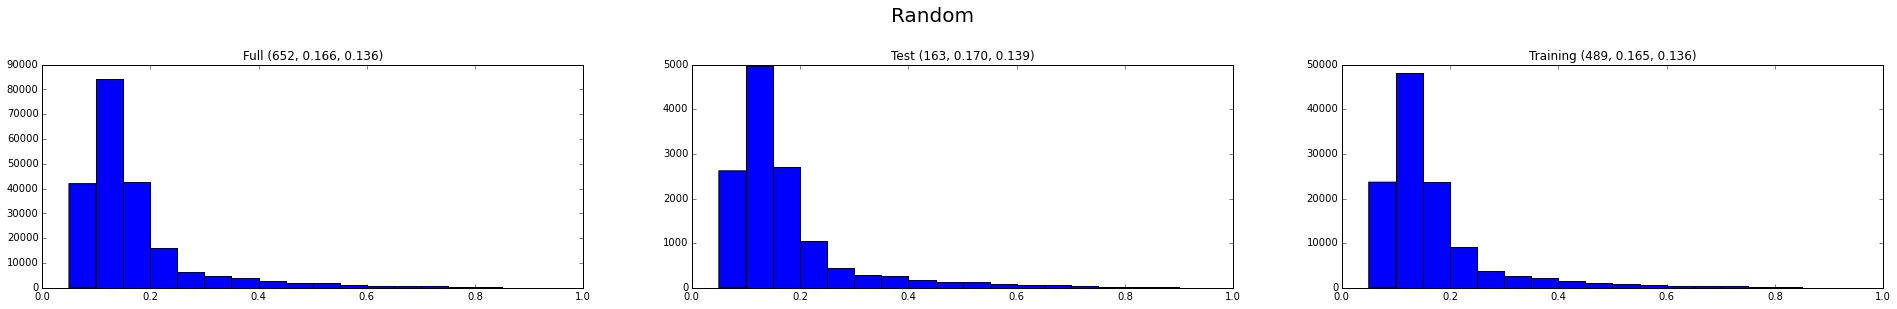

In [111]:
_ = plot_sim_histograms(sims, test_indices1, title='Random')

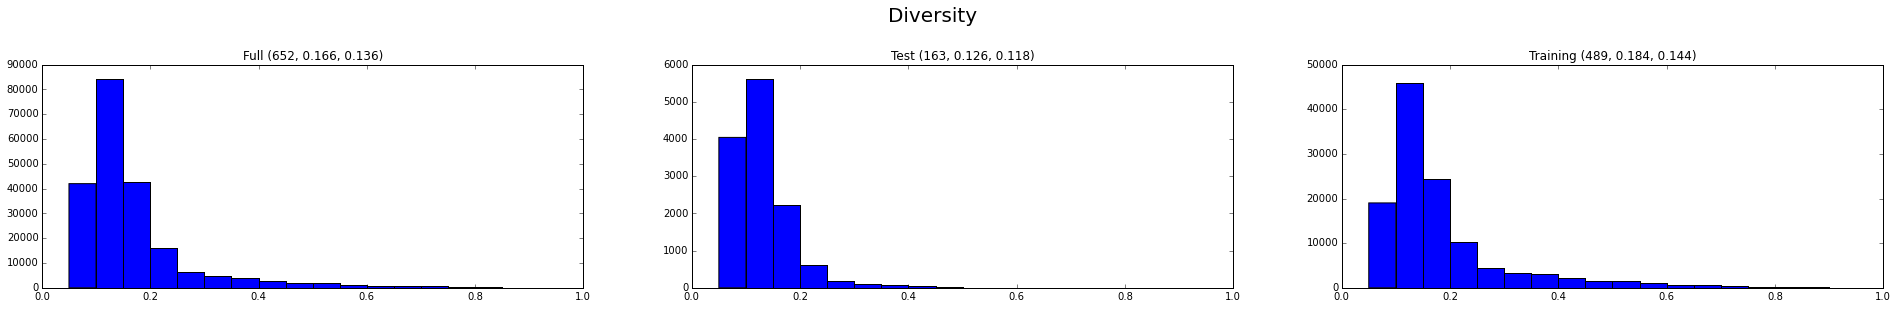

In [112]:
_ = plot_sim_histograms(sims, test_indices2, title='Diversity')

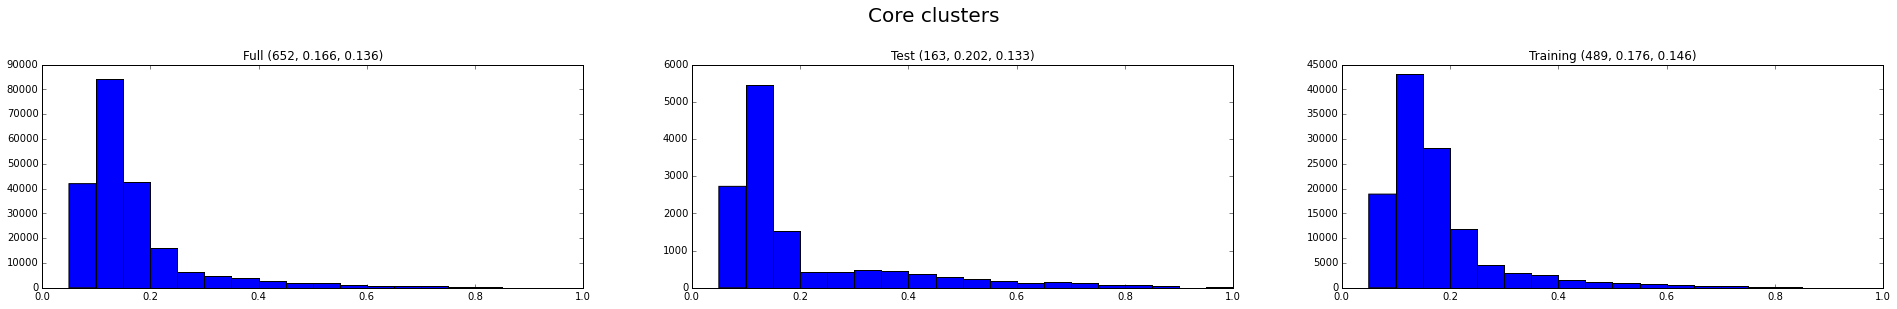

In [113]:
_ = plot_sim_histograms(sims, test_indices3, title='Core clusters')

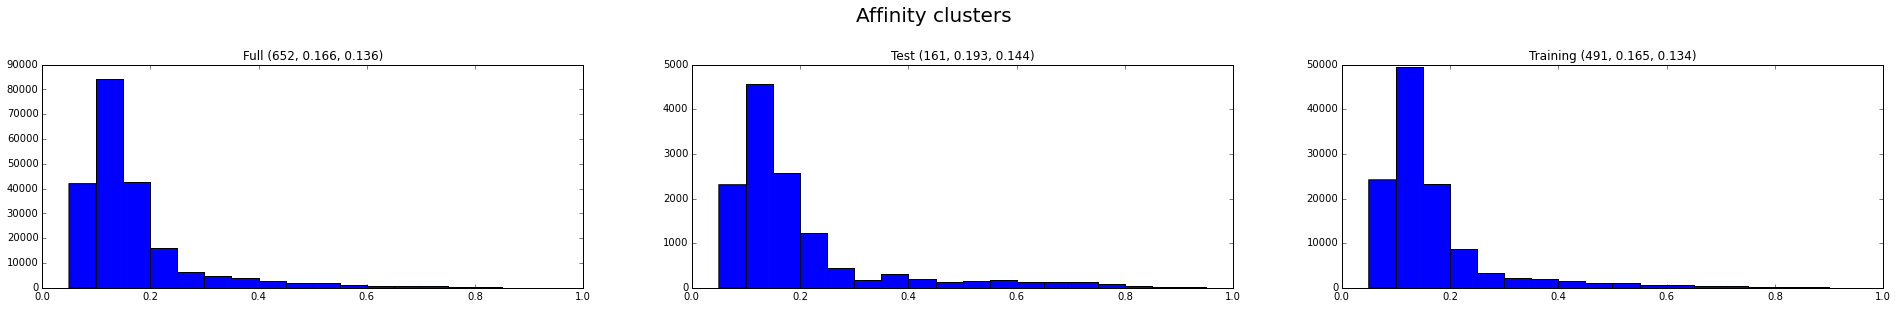

In [114]:
_ = plot_sim_histograms(sims, test_indices4, title='Affinity clusters')

## Multiple random picks

In [115]:
# def f():

#     indices = np.random.choice(range(df.shape[0]), size=target_n, replace=False)
    
#     return sims.query("i in @indices and j in @indices")['sim'].tolist() # Test set

# test_sims = [f() for x in range(16)]

# fig, axes = plt.subplots(4, 4)

# fig.set_size_inches(60, 30)

# width = 0.05

# for n, (test_sim, axis) in enumerate(zip(test_sims, axes.flat), 1):
    
#     axis.hist(test_sim, bins=np.arange(0.0 + width, 1.0 + width, width))
    
#     axis.set_title("{:2d}) {:.3f}, {:.3f}".format(n, np.mean(test_sim), np.median(test_sim)), fontsize=20)